In [29]:
# !pip install pymc3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
%matplotlib inline
import numpy as np

In this notebook I will fit a Gaussian processes model to the results of the optimization process. 

In [19]:
df = pd.read_csv('./data/all_methods_results.csv')
df.head()

,Unnamed: 0,parameters,basis,mean_test_score,mean_train_score,test_scores,train_scores,method,completed,n_clusters,n_components,lag_time
0,0,"{'tica__lag_time': 868, 'close_cont__scheme': ...",close_cont,1.365817,2.961204,"[1.3776911158951748, 1.3740749840217341, 1.264...","[2.9389462312306645, 2.950642052871998, 2.9298...",bayesian,2017-06-25 13:14:13.918401,216,7,868
1,1,"{'msm__prior_counts': 0, 'tica__commute_mappin...",chi_tor,1.102779,1.986818,"[1.0684842211915222, 1.1161358818514298, 1.143...","[2.0313664449993496, 1.902029834442478, 1.9717...",bayesian,2017-06-25 13:13:35.581546,719,8,123
2,2,"{'tica__lag_time': 528, 'cluster__max_no_impro...",alpha_angle,1.599413,2.996799,"[1.419293959877178, 2.459780516990084, 1.42471...","[2.9952122086182973, 2.9991551430503254, 2.996...",bayesian,2017-06-25 13:15:14.257250,503,9,528
3,3,"{'tica__shrinkage': None, 'cluster__random_sta...",all_tor,1.921110,2.992483,"[1.266771869867596, 2.1699129867494955, 2.1975...","[2.9829218758783957, 2.994692237174925, 2.9937...",bayesian,2017-06-25 13:13:47.457845,245,6,909
4,4,"{'msm__verbose': False, 'close-h_cont__soft_mi...",close-h_cont,1.665484,2.997487,"[1.502631858780357, 2.094233568665083, 1.25880...","[2.998903280162028, 2.993679670790958, 2.99892...",bayesian,2017-06-25 13:19:46.849272,990,10,228


Our input variables are the:
1. basis set (categorical)
2. Tica lag time (integer), 
3. Number of tica components (integeter),
4. Number of cluster centers. 

We will need to extract these and then sub sample our data, stratified across the different basis sets. 
I will treat the observations the same even though they were sampled differently. 

In [25]:
df = df.loc[:, ['basis', 'mean_test_score', 'n_clusters', 'n_components', 'lag_time']]
sample = df.groupby(['basis']).apply(lambda x: x.sample(n=100))
sample.head()

basis  mean_test_score  n_clusters  n_components  lag_time
basis                                                                     
all_tor 5485  all_tor         1.467002         554             8        42
        5614  all_tor         1.960126         365             1       221
        1667  all_tor         2.157969         352             3       199
        1647  all_tor         1.736274         651             9       995
        1695  all_tor         1.738674         349             6       272

### Example: all_tor

### Pairwise correlations

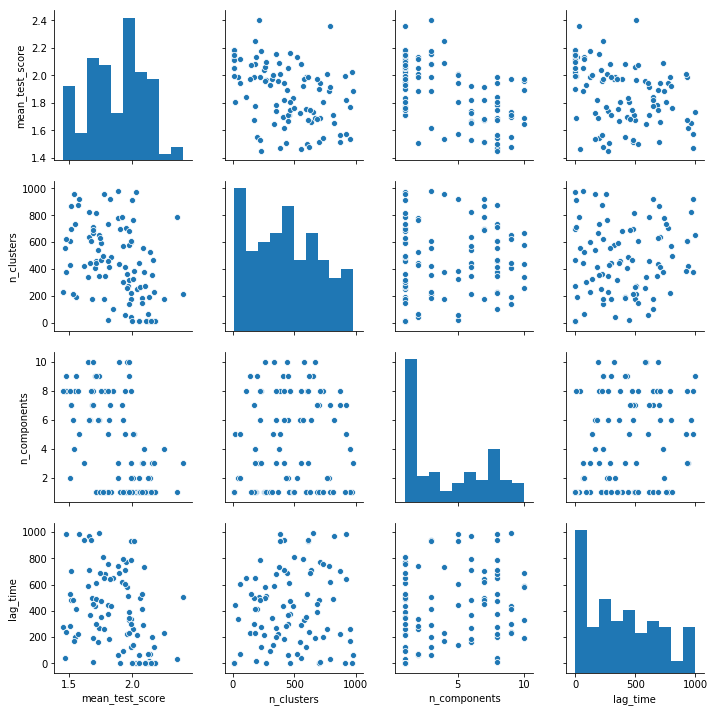

In [27]:
sns.pairplot(sample.query("basis=='all_tor'"))

### Model


In [59]:
X = sample.query("basis=='all_tor'").loc[:, ['n_clusters', 'n_components', 'lag_time']]
X = X.values
y = sample.query("basis=='all_tor'").mean_test_score
print(X.shape, y.shape)

(100, 3) (100,)


In [63]:
with pm.Model() as model:

    # latent function
    eta = pm.HalfCauchy("eta", beta=2, testval=2.0)
    length = pm.Gamma("length", alpha=4, beta=0.1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, length)
    gp = pm.gp.Marginal(cov_func=cov)

#     # noise model
#     η_noise = pm.HalfNormal("η_noise", sd=0.5, testval=0.05)
#     ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
#     σ  = pm.HalfNormal("σ",  sd=0.25, testval=0.05)
#     cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
#                 pm.gp.cov.WhiteNoise(σ)

#     # The Gaussian process is a sum of these three components
#     gp = gp_seasonal + gp_medium + gp_trend
    sigma = pm.HalfCauchy("sigma", beta=3)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=X[:,0][:, np.newaxis], y=y, noise=sigma)
    
    # Now sample
    trace = pm.sampling.sample(tune=1000, draws=1000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, length, eta]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:28<00:00, 139.42draws/s]


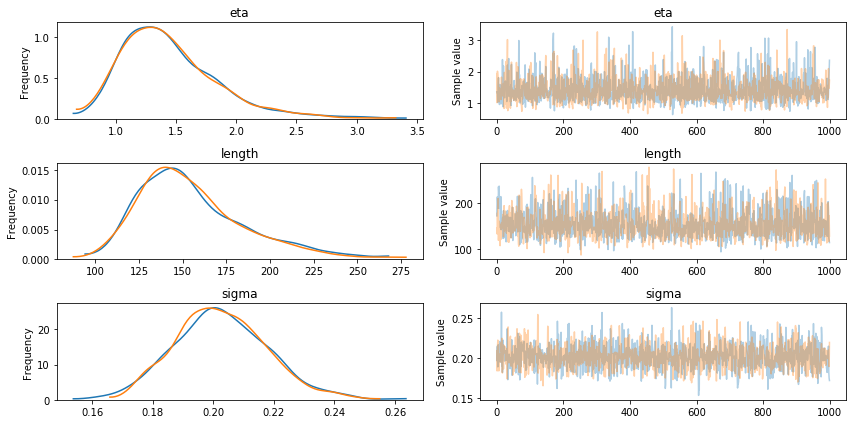

In [64]:
axes = pm.traceplot(trace)


In [65]:
pm.diagnostics.gelman_rubin(trace)

{'eta': 0.9997192043953796,
 'length': 0.9996817665853784,
 'sigma': 0.9995034952168204}

### Predictive checking

In [67]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)


  0%|          | 0/500 [00:00<?, ?it/s]/anaconda3/envs/py35/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 500/500 [00:05<00:00, 91.01it/s] 


In [86]:
ppc.keys()

dict_keys(['y'])

In [84]:
mu

NameError: name 'mu' is not defined